In [1]:
import numpy as np
import random
import math
from scipy.stats import beta
import networkx as nx
import pandas as pd

from mesa import Model, Agent
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from matplotlib import animation
from IPython.display import HTML, display

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import mpmath 
from mpmath import mp
mp.prec = 100
sns.set()
from tqdm.notebook import tqdm
from itertools import starmap

matplotlib.rcParams['figure.figsize'] = (7, 5)


In [2]:
def prob_ev_discount(bel_ev, m, dist):
    
    return 1 -  (min(1, dist*m) * (1 - bel_ev))
    
def prob_ev_antiupdate(bel_ev, m, dist): 
    
    return max(1 - (dist * m * (1 - bel_ev)), 0)


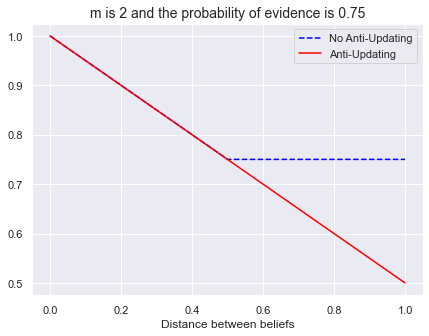

In [3]:

m = 2
bel_ev = 0.75
xs = np.linspace(0, 1, 1000)

plt.plot(xs, [prob_ev_discount(bel_ev, m, d) for d in xs], '--',color="blue", label="No Anti-Updating")
plt.plot(xs, [prob_ev_antiupdate(bel_ev, m, d) for d in xs], color="red", label='Anti-Updating')
plt.xlabel("Distance between beliefs")
plt.title(f"m is {m} and the probability of evidence is {bel_ev}", fontsize=14)
plt.legend();



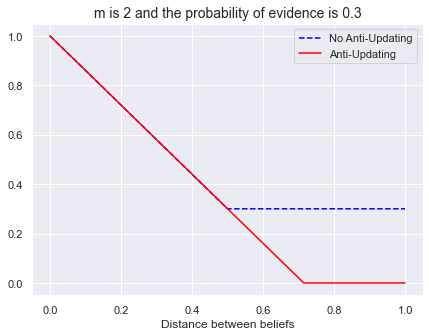

In [4]:
m = 2
bel_ev = 0.3
xs = np.linspace(0, 1, 1000)

plt.plot(xs, [prob_ev_discount(bel_ev, m, d) for d in xs], '--',color="blue", label="No Anti-Updating")
plt.plot(xs, [prob_ev_antiupdate(bel_ev, m, d) for d in xs], color="red", label='Anti-Updating')
plt.xlabel("Distance between beliefs")
plt.title(f"m is {m} and the probability of evidence is {bel_ev}", fontsize=14)
plt.legend();



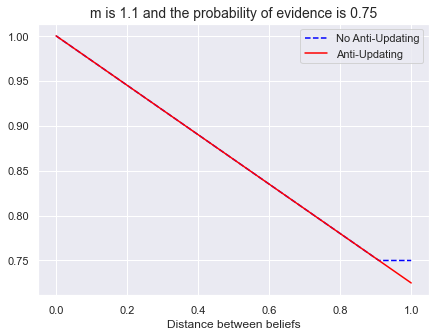

In [5]:

m = 1.1
bel_ev = 0.75
xs = np.linspace(0, 1, 1000)

plt.plot(xs, [prob_ev_discount(bel_ev, m, d) for d in xs], '--',color="blue", label="No Anti-Updating")
plt.plot(xs, [prob_ev_antiupdate(bel_ev, m, d) for d in xs], color="red", label='Anti-Updating')
plt.xlabel("Distance between beliefs")
plt.title(f"m is {m} and the probability of evidence is {bel_ev}", fontsize=14)
plt.legend();


In [6]:
def generate_prior_two_acts(): 
    pr1 = np.random.uniform(0,1)
    return pr1, 1-pr1

def generate_prior(num_acts): 
    return list(np.random.dirichlet((1,)*num_acts))


class SimpleAction(object):
    
    def __init__(self, prob_success):
        
        assert prob_success >= 0 and prob_success <= 1, f"{prob_success} must be between 0 and 1"
        self.prob_success = prob_success
        
    def execute(self, num = 1): 
        
        return np.random.binomial(num, self.prob_success) 
        
    def pr(self, num_success, total):
        
        assert num_success <= total, f"the successes {num_success} cannot be greater than the total {total}"
        return mp.mpf(self.prob_success)**mp.mpf(num_success) * mp.mpf((1 - self.prob_success))**mp.mpf((total - num_success))

    def __str__(self):
        return f"P(s)={self.prob_success}"
    
class Learner(Agent):
    
    def __init__(self, unique_id, model,  m, known_mean, acts, pos, default_num_trials = 1000, anti_updating = False):
        super().__init__(unique_id, model)
        self.known_mean = known_mean
        self.default_num_trials = default_num_trials
        self.acts = acts
        self.m = m # parameter 
        self.anti_updating = anti_updating
        
        self.num_success = 0 # number of successes of the current experiment
        self.num_trials = 0 # number of times the current experiment was performed
        if len(acts) == 2:
            prior = generate_prior_two_acts()
            self.pr = {acts[0]: prior[0], acts[1]: prior[1]} 
        else:
            prior = generate_prior(len(acts))
            self.pr = {a: prior[a_idx] for a_idx,a in enumerate(acts)}
        self.pos = pos
        
    def belief(self, act):
        return self.pr[act]
        
    def update_bayes(self, num_success, num_trials): 
        '''update using Bayes Theorem'''
        new_bel = dict()
        for act in self.pr.keys():
            new_bel[act] = act.pr(num_success, num_trials) * self.pr[act] / sum((self.pr[_a] * _a.pr(num_success, num_trials) for _a in self.acts))
        self.pr = new_bel
        
    def update_jeffrey(self, num_success, num_trials, dist): 
        
        # assumes that there are two acts and act1 is the act that we are receiving evidence about
        act1 = self.acts[0]
        act2 = self.acts[1]
        
        pr_ev = self.pr[act1] * act1.pr(num_success, num_trials) + self.pr[act2] * act2.pr(num_success, num_trials)

        pr_act1_given_ev = act1.pr(num_success, num_trials) * self.pr[act1] / pr_ev
        pr_act1_given_nev = (1 - act1.pr(num_success, num_trials)) * self.pr[act1] / (1-pr_ev)
        
        if self.anti_updating: 
            discounted_bel_ev = prob_ev_antiupdate(pr_ev, self.m, dist)
        else: 
            discounted_bel_ev = prob_ev_discount(pr_ev, self.m, dist)
            
        new_bel_act1 = pr_act1_given_ev * discounted_bel_ev  + pr_act1_given_nev * (1 - discounted_bel_ev)
        
        self.pr[act1] = new_bel_act1
        self.pr[act2] = 1 - new_bel_act1
        
    def choice(self):
        act = max(self.pr.items(), key = lambda p: p[1])[0]
        if act.prob_success > self.known_mean:
            return act
        else: 
            return None
    
    def experiment(self, num_trials = None): 
                
        act = self.choice()

        if act is not None:
            num_trials = num_trials if num_trials is not None else self.default_num_trials
            self.num_success = act.execute(num=num_trials)
            self.num_trials = num_trials
        else: 
            self.num_success = 0
            self.num_trials = 0
    
class BGModel(Model):
    
    def __init__(self, network, m, acts, true_act, known_mean, 
                 default_num_trials = 1000, 
                 anti_updating = False, 
                 bayes_update = True):
                
        self.acts = acts
        self.true_act = true_act 
        self.known_mean = known_mean
        self.schedule = RandomActivation(self)
        self.network = NetworkGrid(network)
        self.m = m
        self.bayes_update = bayes_update
        self.running = True
        
        # Set up agents
        agent_id = 0
        for n in network.nodes:
            agent = Learner(agent_id, 
                             self, 
                             m, # resistence to learning from others
                             self.known_mean, 
                             self.acts, 
                             n, # position in network
                             default_num_trials = default_num_trials, 
                             anti_updating = anti_updating)
            self.network.place_agent(agent, n)
            self.schedule.add(agent)
            agent_id += 1
        
    def converged(self): 
        
        if all([a.belief(self.true_act) > mp.mpf(0.99) for a in self.schedule.agents]): 
            return 1 # beliefs converged on the true act
        elif all([a.choice() is None for a in self.schedule.agents]): 
            return 0 # no longer experimenting
        else: 
            return -1 # undecided
        
    def is_polarized(self): 
        
        is_polarized = False
        beliefs = [a.belief(self.true_act) for a in self.schedule.agents]
        if all([b > mp.mpf(0.99) or b < mp.mpf(0.5) for b in beliefs]) and any([b < mp.mpf(0.5) for b in beliefs]) and any([b > mp.mpf(0.99) for b in beliefs]):
            
            min_belief = min(beliefs)
            max_belief = max(beliefs)
            
            is_polarized = self.m * (max_belief - min_belief) >= 1
        
        return is_polarized
    
    def step(self, num_tests = None):
        
        # all the agents perform their experiments
        for a in self.schedule.agents:
            a.experiment(num_tests)
        
            
        for a in self.schedule.agents:
            
            if self.bayes_update:
            
                total_success = 0
                total_trials = 0
                # neighbors include a
                neighbors_nodes = [n_pos for n_pos in self.network.get_neighbors(a.pos, include_center = True)]
                neighbors = [n for n in self.schedule.agents if n.pos in neighbors_nodes]
                for n in neighbors: 
                    total_success += n.num_success
                    total_trials += n.num_trials
                a.update_bayes(total_success, total_trials)
            
            
            else: # use Jeffrey update
                
                # first update on your own experiment
                a.update_bayes(a.num_success, a.num_trials)
                
                # use Jeffrey update on neighbors
                neighbors_nodes = [n_pos for n_pos in self.network.get_neighbors(a.pos, include_center = True)]
                neighbors = [n for n in self.schedule.agents if n.pos in neighbors_nodes]

                for n in neighbors: 
                    if n.num_trials > 0: #n performed an experiment
                        dist = math.fabs(a.belief(self.true_act) - n.belief(self.true_act))
                        a.update_jeffrey(n.num_success, n.num_trials, dist)
                
        if self.converged() in [0,1] or (not self.bayes_update and self.is_polarized()):
            self.running = False


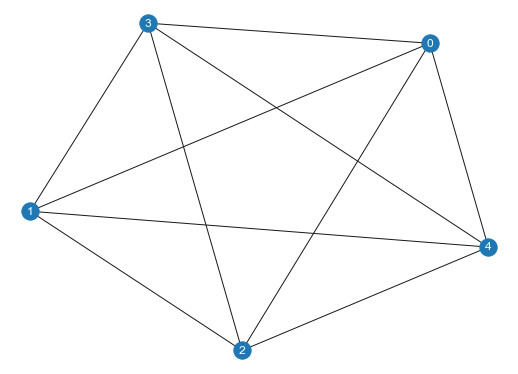

<Figure size 504x360 with 0 Axes>

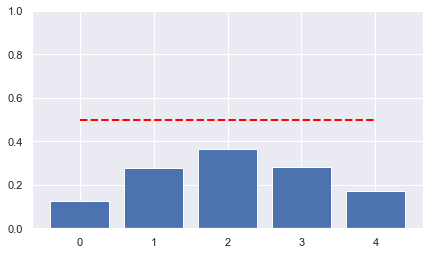

In [7]:
epsilon = 0.01
num_agents = 5
known_mean = 0.5
true_act = SimpleAction(known_mean + epsilon)
acts = [true_act, SimpleAction(known_mean - epsilon)]
num_experts = 5
default_num_trials = 100
bayes_update = True
anti_updating = False
m = 2

#G=nx.empty_graph(num_agents)
G=nx.complete_graph(num_agents)

nx.draw(G, with_labels=True, font_color='white')
plt.show();
plt.clf()
fig, ax = plt.subplots(figsize=(7, 4))
m = 2

model = BGModel(G, m, acts, true_act, known_mean, default_num_trials = default_num_trials, bayes_update = bayes_update, anti_updating = anti_updating)

ax.bar([str(a.unique_id) for a in model.schedule.agents], 
       [a.belief(true_act) for a in model.schedule.agents])  

ax.plot([str(a.unique_id) for a in model.schedule.agents], 
        [known_mean]*len(model.schedule.agents), 
        '--', color='red',lw=2)
ax.set_ylim(0,1)
plt.show();

def draw_barchart(num):
    model.step()
    ax.clear()
    ax.bar([str(a.unique_id) for a in model.schedule.agents],
           [a.belief(true_act) for a in model.schedule.agents])   
    ax.plot([str(a.unique_id) for a in model.schedule.agents], 
            [known_mean]*len(model.schedule.agents), '--', color='red',lw=2)     
    ax.set_ylim(0,1)
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 100), interval=1)
HTML(animator.to_jshtml())


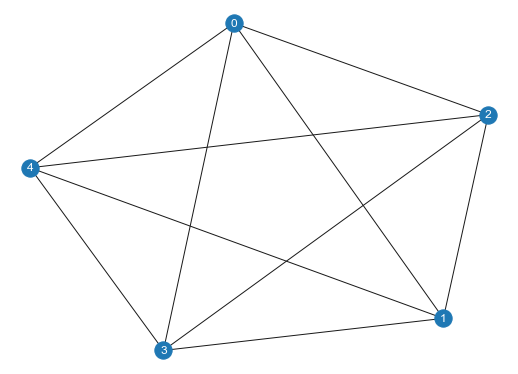

<Figure size 504x360 with 0 Axes>

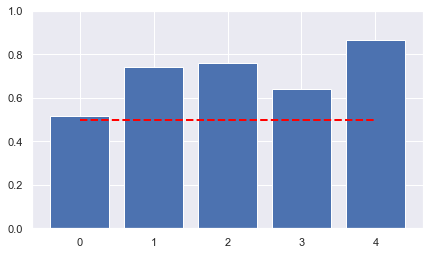

In [8]:
epsilon = 0.01
num_agents = 5
known_mean = 0.5
true_act = SimpleAction(known_mean + epsilon)
acts = [true_act, SimpleAction(known_mean - epsilon)]
num_experts = 5
default_num_trials = 100
bayes_update = False
anti_updating = False
m = 2

#G=nx.empty_graph(num_agents)
G=nx.complete_graph(num_agents)

nx.draw(G, with_labels=True, font_color='white')
plt.show();
plt.clf()
fig, ax = plt.subplots(figsize=(7, 4))
m = 2

model = BGModel(G, m, acts, true_act, known_mean, default_num_trials = default_num_trials, bayes_update = bayes_update, anti_updating = anti_updating)

ax.bar([str(a.unique_id) for a in model.schedule.agents], 
       [a.belief(true_act) for a in model.schedule.agents])  

ax.plot([str(a.unique_id) for a in model.schedule.agents], 
        [known_mean]*len(model.schedule.agents), 
        '--', color='red',lw=2)
ax.set_ylim(0,1)
plt.show();

def draw_barchart(num):
    model.step()
    ax.clear()
    ax.bar([str(a.unique_id) for a in model.schedule.agents],
           [a.belief(true_act) for a in model.schedule.agents])   
    ax.plot([str(a.unique_id) for a in model.schedule.agents], 
            [known_mean]*len(model.schedule.agents), '--', color='red',lw=2)     
    ax.set_ylim(0,1)
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 100), interval=1)
HTML(animator.to_jshtml())


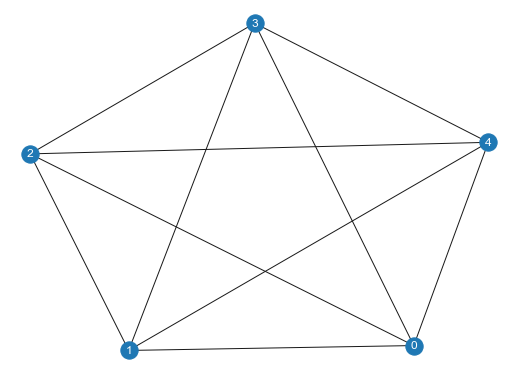

<Figure size 504x360 with 0 Axes>

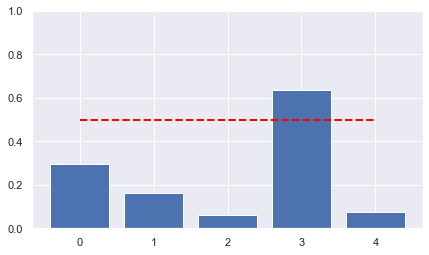

In [9]:
epsilon = 0.01
num_agents = 5
known_mean = 0.5
true_act = SimpleAction(known_mean + epsilon)
acts = [true_act, SimpleAction(known_mean - epsilon)]
num_experts = 5
default_num_trials = 100
bayes_update = False
anti_updating = True
m = 2

#G=nx.empty_graph(num_agents)
G=nx.complete_graph(num_agents)

nx.draw(G, with_labels=True, font_color='white')
plt.show();
plt.clf()
fig, ax = plt.subplots(figsize=(7, 4))
m = 2

model = BGModel(G, m, acts, true_act, known_mean, default_num_trials = default_num_trials, bayes_update = bayes_update, anti_updating = anti_updating)

ax.bar([str(a.unique_id) for a in model.schedule.agents], 
       [a.belief(true_act) for a in model.schedule.agents])  

ax.plot([str(a.unique_id) for a in model.schedule.agents], 
        [known_mean]*len(model.schedule.agents), 
        '--', color='red',lw=2)
ax.set_ylim(0,1)
plt.show();

def draw_barchart(num):
    model.step()
    ax.clear()
    ax.bar([str(a.unique_id) for a in model.schedule.agents],
           [a.belief(true_act) for a in model.schedule.agents])   
    ax.plot([str(a.unique_id) for a in model.schedule.agents], 
            [known_mean]*len(model.schedule.agents), '--', color='red',lw=2)     
    ax.set_ylim(0,1)
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 100), interval=1)
HTML(animator.to_jshtml())
